In [ ]:

import os
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
from scipy.io import loadmat, savemat
import glob
import re
import sionna.rt
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, \
                      PathSolver, RadioMapSolver, subcarrier_frequencies, SceneObject, ITURadioMaterial, RadioMaterialBase
plt.rcParams['figure.figsize'] = [12, 8] # Set default plot size



In [ ]:
def beamforming_codebook(ant_shape = np.array([1, 32, 1]), oversampling_rate = np.array([1, 1, 1]), kd = 0.5):

    kd = 2 * np.pi * kd
    codebook_size = ant_shape * oversampling_rate

    vecs = []
    for dim in range(3):
        ind = np.arange(ant_shape[dim]).reshape((-1, 1))
        codebook_ang = np.linspace(0, np.pi, codebook_size[dim], endpoint = False).reshape((1, -1))
        vec = np.sqrt(1./ant_shape[dim]) * np.exp(-1j * kd * ind * np.cos(codebook_ang))
        vecs.append(vec)

    F = np.kron(vecs[2], np.kron(vecs[1], vecs[0]))

    return F



In [ ]:
scene = load_scene(sionna.rt.scene.simple_street_canyon, merge_shapes= False)

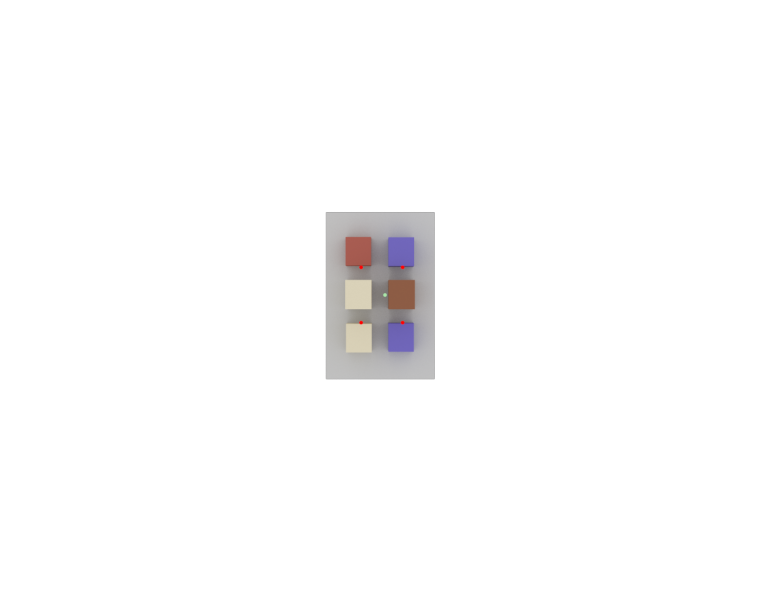

In [ ]:
my_cam = Camera(position=[0,0,1000], look_at=[0,0, 0])

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="hw_dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="hw_dipole",
                             polarization="V")

tx_positions = [
    [-30, -24, 30],
    [30, -24, 30],
    [-30, 21,  30],
    [30, 21, 30]
]

# Create a receiver
rx = Receiver(name="rx",
              position=[0,-5,10],
              display_radius=2)

# Add receiver instance to scene
scene.add(rx)

for i, pos in enumerate(tx_positions):
    tx = Transmitter(name=f"tx{i+1}", position=pos, display_radius=2)
    scene.add(tx)
    tx.look_at(rx)
scene.render(camera=my_cam, resolution=[1300, 1000], num_samples=1024);

In [ ]:
scene.objects

{'building_1': <sionna.rt.scene_object.SceneObject at 0x780ab7649e50>,
 'building_6': <sionna.rt.scene_object.SceneObject at 0x780a554063d0>,
 'building_5': <sionna.rt.scene_object.SceneObject at 0x780ab6d9dd10>,
 'building_4': <sionna.rt.scene_object.SceneObject at 0x780a55430290>,
 'building_3': <sionna.rt.scene_object.SceneObject at 0x780ab6d9e890>,
 'building_2': <sionna.rt.scene_object.SceneObject at 0x780a55431e50>,
 'floor': <sionna.rt.scene_object.SceneObject at 0x780a55431f10>}

In [ ]:
elm_12 = scene.get('building_1')
elm_13 = scene.get('building_2')
elm_14 = scene.get('building_3')
elm_15 = scene.get('building_4')
elm_16 = scene.get('building_5')
elm_17 = scene.get('building_6')
elm_12.radio_material

ITURadioMaterial type=glass
                 eta_r=6.310
                 sigma=0.019
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

In [ ]:
print(elm_12.position)
print(elm_13.position)
print(elm_14.position)
print(elm_15.position)
print(elm_16.position)
print(elm_17.position)
elm_12.position = [-46, -38, 10.8923]
elm_13.position = [48, 40, 10.8923]
elm_14.position = [-46, 39, 14.5334]
elm_15.position = [0.441744, 39, 25.4565]
elm_16.position = [47, -38, 14.5334]
elm_17.position = [0.441744, -38, 25.4565]

[[-46.5469, -22.5565, 10.8923]]
[[47.9174, 24.2804, 10.8923]]
[[-46.8507, 23.5147, 14.5334]]
[[0.441744, 23.5147, 25.4565]]
[[47.0795, -22.5565, 14.5334]]
[[0.441744, -22.5565, 25.4565]]


In [ ]:
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

In [ ]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

Shape of a:  (1, 1, 4, 1, 16, 1)
Shape of tau:  (1, 1, 4, 1, 16)


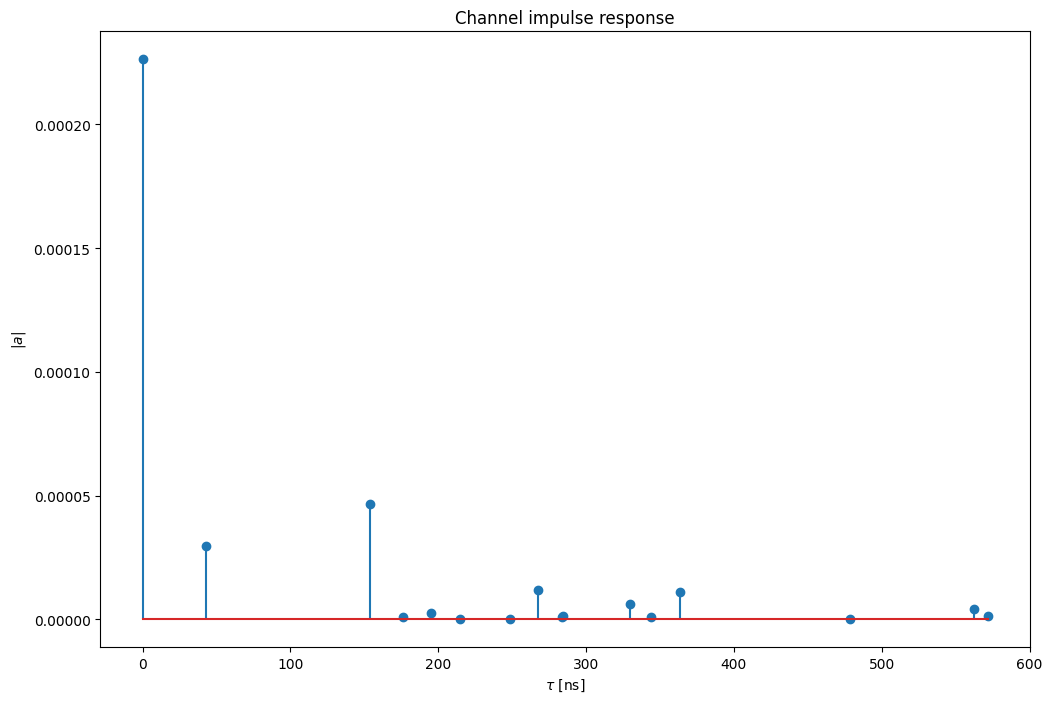

In [ ]:
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

In [ ]:
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

Shape of h_freq:  (1, 1, 4, 1, 1, 1024)


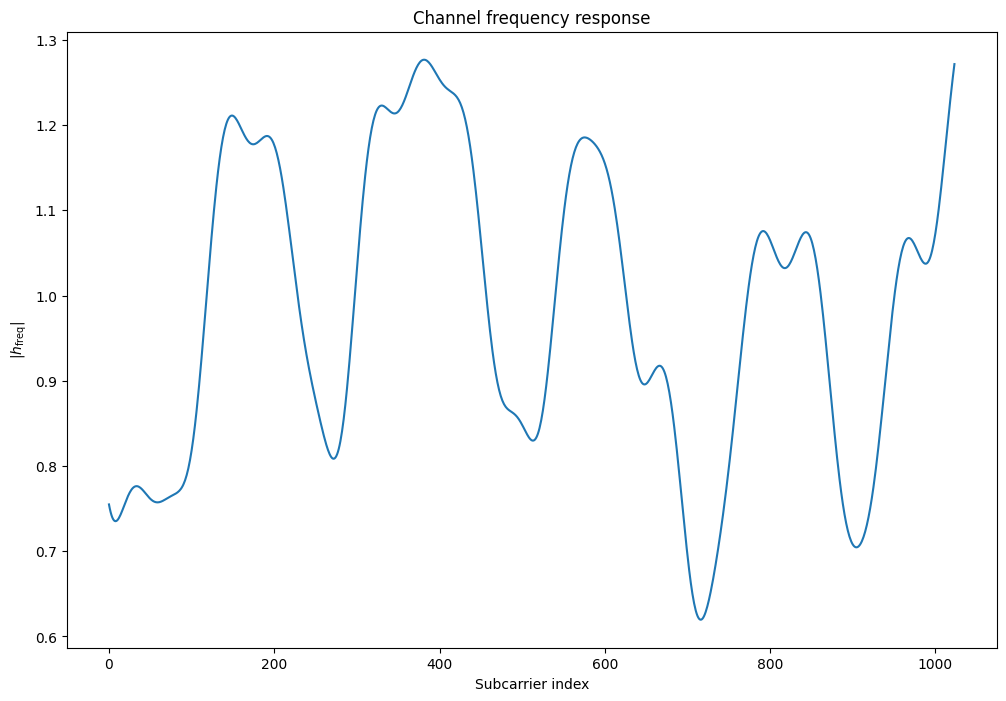

In [ ]:
num_subcarriers = 1024
subcarrier_spacing=30e3

# Compute frequencies of subcarriers relative to the carrier frequency
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

# Compute channel frequency response
h_freq = paths.cfr(frequencies=frequencies,
                   normalize=True,
                   normalize_delays=True,
                   out_type="numpy")

print("Shape of h_freq: ", h_freq.shape)

plt.figure()
plt.plot(np.abs(h_freq)[0,0,0,0,0,:]);
plt.xlabel("Subcarrier index");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");

Shape of taps:  (1, 1, 4, 1, 1, 107)


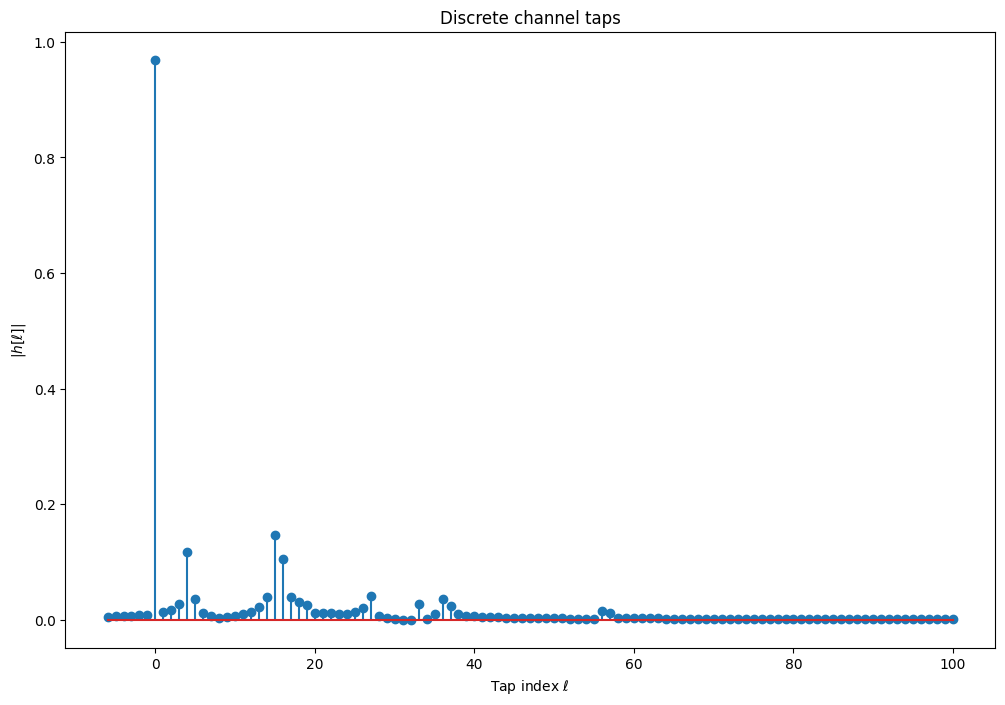

In [ ]:
taps = paths.taps(bandwidth=100e6, # Bandwidth to which the channel is low-pass filtered
                  l_min=-6,        # Smallest time lag
                  l_max=100,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
print("Shape of taps: ", taps.shape)

plt.figure()
plt.stem(np.arange(-6, 101), np.abs(taps)[0,0,0,0,0]);
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");

In [ ]:
# Recompute propagation paths
paths_mob = p_solver(scene=scene,
                     max_depth=5,
                     los=True,
                     specular_reflection=True,
                     diffuse_reflection=False,
                     refraction=True,
                     synthetic_array=True,
                     seed=41)

# Compute CIR with time-evolution
num_time_steps=100
sampling_frequency = 1e4
a_mob, _ = paths_mob.cir(sampling_frequency=sampling_frequency,
                         num_time_steps=num_time_steps,
                         out_type="numpy")

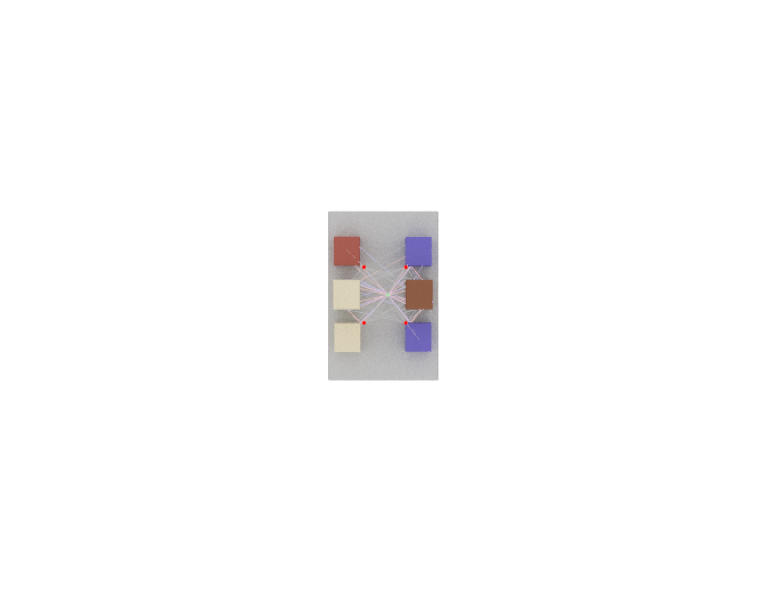

In [ ]:
scene.render(camera=my_cam, paths=paths_mob, clip_at=1000);

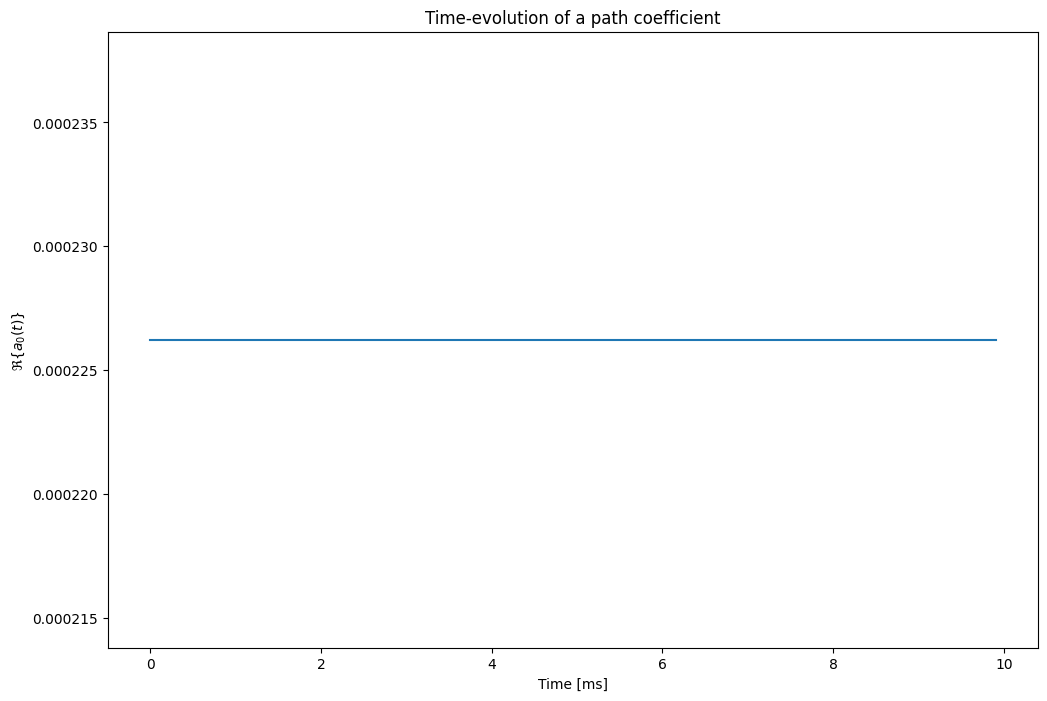

In [ ]:
# Inspect time-evolution of a single path coefficient
plt.figure()
plt.plot(np.arange(num_time_steps)/sampling_frequency*1000,
         a_mob[0,0,0,0,0].real);
plt.xlabel("Time [ms]");
plt.ylabel(r"$\Re\{a_0(t) \}$");
plt.title("Time-evolution of a path coefficient");

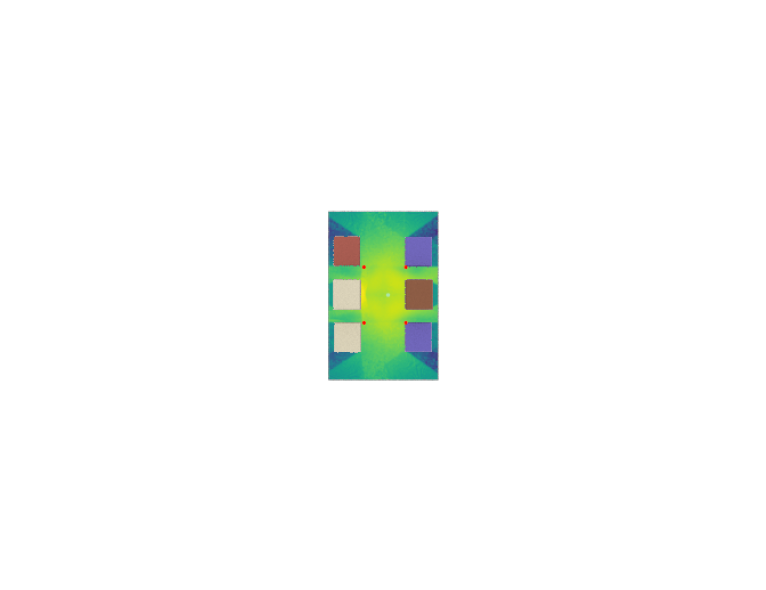

In [ ]:
rm_solver = RadioMapSolver()

rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[1,1],
               samples_per_tx=10**6)


scene.render(camera=my_cam, radio_map=rm);

In [ ]:
print("Interactions: \n", paths.interactions.numpy()[:,0,0,0,0,:])

print("Number of paths: ", paths.interactions.shape[-1])

Interactions: 
 [[0 4 1 4 4 4 4 4 4 4 1 4 4 4 1 1]
 [0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 4]
 [0 1 0 4 1 1 4 1 1 1 0 1 1 4 0 1]
 [0 1 0 0 4 4 1 4 1 4 0 4 4 1 0 1]
 [0 4 0 0 0 0 0 0 4 1 0 1 0 1 0 4]]
Number of paths:  16


In [ ]:
from tqdm import tqdm
channel_data = None
for i in tqdm(range(100), desc="Outer Loop"):
  for j in range(181):
      scene.remove("rx")
      rx = Receiver(name="rx",
                    position=[-30 + j * (120/181),-24 + i * (45/100), 10],
                    display_radius=2)

      scene.add(rx)

      for k, pos in enumerate(tx_positions):
          scene.remove(f"tx{k+1}")
          tx = Transmitter(name=f"tx{k+1}", position=pos, display_radius=2)
          scene.add(tx)
          tx.look_at(rx)

      p_solver  = PathSolver()

      paths = p_solver(scene=scene,
                      max_depth=5,
                      los=True,
                      specular_reflection=True,
                      diffuse_reflection=False,
                      refraction=True,
                      synthetic_array=False,
                      seed=41)
      num_subcarriers = 64
      subcarrier_spacing=50e6 / num_subcarriers

      # Compute frequencies of subcarriers relative to the carrier frequency
      frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

      # Compute channel frequency response
      h_freq = paths.cfr(frequencies=frequencies,
                        normalize=True, # Normalize energy
                        normalize_delays=True,
                        out_type="numpy")
      if channel_data is None:
        channel_data = h_freq
      else:
        channel_data = np.concatenate((channel_data, h_freq), axis=0)


Outer Loop:   5%|▌         | 5/100 [02:20<44:01, 27.80s/it]/usr/local/lib/python3.11/dist-packages/drjit/ast.py:838: RuntimeWarning: The AST-transforming decorator @drjit.syntax was called more than 1000 times by your program. Since transforming and recompiling Python code is a relatively expensive operation, it should not be used within loops or subroutines. Please move the function to be transformed to the top program level and decorate it there.
  warnings.warn(
Outer Loop: 100%|██████████| 100/100 [50:00<00:00, 30.01s/it]


In [ ]:
savemat('DLCB_input_squeezed.mat', {'DL_input': channel_data.squeeze()})

In [ ]:
savemat('DLCB_input_.mat', {'DL_input': channel_data})

In [ ]:
sionna_data = loadmat('DLCB_input_squeezed.mat')

In [ ]:
print(sionna_data['DL_input'])

[[[-0.9980769 -6.19843975e-02j -0.15479003+9.87947166e-01j
    0.96920604+2.46250272e-01j ...  0.5005693 +8.65696251e-01j
    0.90860444-4.17657137e-01j -0.33110154-9.43594873e-01j]
  [-0.601216  -3.11445266e-01j -1.2097094 +1.25127420e-01j
   -0.9888988 +1.20893908e+00j ...  0.90725386+5.59648454e-01j
    1.2215693 +1.98088437e-01j  1.3571116 -6.37447238e-01j]
  [ 0.81534505+1.34746104e-01j  0.9541507 +1.03828996e-01j
    0.90035725+3.96183245e-02j ...  0.95647484-6.52260110e-02j
    0.9840593 -1.15534127e-01j  0.903016  -1.73754200e-01j]
  [ 1.0962011 -1.41799087e-02j  1.0168327 -6.32803068e-02j
    0.9798371 -1.71357524e-02j ...  1.0554949 -9.05005075e-03j
    1.0612608 -1.28321443e-02j  1.098116  -8.45303386e-02j]]

 [[ 1.0700575 -1.13992222e-01j  0.87812376-1.92391559e-01j
    0.6481055 -1.30810499e-01j ...  0.98134804+3.25382590e-01j
    1.1466705 +1.59495726e-01j  1.1248646 -9.35624316e-02j]
  [-0.9124434 +2.80683249e-01j -0.11657212+6.72865808e-01j
    0.43518087-9.82063562e-02

In [ ]:
print(sionna_data['DL_input'].shape)

(18100, 4, 64)


In [ ]:
# Define antenna shape and spacing (BS-side)
ant_shape = [1, 1, 64]  # Based on DeepMIMO config
kd = 0.5  # Half-wavelength spacing

# Generate beamforming codebook
F = beamforming_codebook(ant_shape=ant_shape, oversampling_rate=np.array([1, 2, 1]), kd=kd)

# Extract info from Sionna data
DL_input = sionna_data['DL_input']  # shape: (18100, 4, 64)
num_ue = DL_input.shape[0]
num_rx_ant = DL_input.shape[1]
num_OFDM = DL_input.shape[2]
num_beams = F.shape[1]
num_bs = 4  # Single base station assumed

# System-level constants
NF = 5  # Noise figure (dB)
Process_Gain = 10  # Processing gain (dB)
BW = 0.5e9  # 500 MHz total bandwidth
subcarriers = 64

# Compute noise power
noise_power_dB = -204 + 10 * np.log10(BW / subcarriers) + NF - Process_Gain
noise_power = 10 ** (0.1 * noise_power_dB)

# Preallocate output arrays
input_norm = np.zeros((num_bs, num_ue, num_OFDM), dtype=complex)
max_rates = np.zeros((num_bs, num_ue, num_beams))


In [ ]:
from tqdm import tqdm

for ue_idx in tqdm(range(num_ue), desc='Neural Network Input-Output Generation-BS', position=0, leave=True):
    for bs_idx in range(num_bs):
        ch = sionna_data['DL_input'][ue_idx, bs_idx, :]
        noise = np.sqrt(noise_power) * (np.random.randn(*ch.shape) + 1j * np.random.randn(*ch.shape))
        ch_noisy = ch + noise
        ch_noisy = np.nan_to_num(ch_noisy)
        input_norm[bs_idx, ue_idx, :] = ch_noisy
        snr = np.abs(ch_noisy)**2
        rate = np.sum(np.log2(1 + snr)) / num_OFDM
        rate = np.nan_to_num(rate)
        max_rates[bs_idx, ue_idx, :] = rate

Neural Network Input-Output Generation-BS: 100%|██████████| 18100/18100 [00:05<00:00, 3035.08it/s]


In [ ]:
# Input reshape - normalize
input_norm = np.transpose(input_norm, axes=[1, 0, 2])
input_norm = input_norm.reshape((num_ue, -1))
input_norm /=  np.amax(np.abs(input_norm))

# Output reshape - normalize
max_rates_norm_factor = np.amax(max_rates, axis=2, keepdims=True)
max_rates_norm_factor[max_rates_norm_factor== 0] = 1 # Do not normalize if all zeros
max_rates /= max_rates_norm_factor
max_rates = np.transpose(max_rates, axes=[1, 0, 2])
max_rates = max_rates.reshape((num_ue, -1))

if not os.path.exists('./Test_dataset'):
                      os.makedirs('Test_dataset')
savemat('./Test_dataset/DLCB_input.mat', {'DL_input': input_norm})
savemat('./Test_dataset/DLCB_output.mat', {'DL_output': max_rates})



In [ ]:
# %% Machine Learning
import os
import keras
import keras.models as models
from keras.layers import Dense,Dropout
import numpy as np

# Model training function
def train(In_train, Out_train, In_test, Out_test,
          epochs, batch_size,dr,
          num_hidden_layers, nodes_per_layer,
          loss_fn,n_BS,n_beams):

    in_shp = list(In_train.shape[1:])

    AP_models = []
    for bs_idx in range(n_BS):
        idx_str = 'BS%i' % bs_idx
        idx = bs_idx*n_beams

        model = models.Sequential()
        model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal', input_shape=in_shp))
        model.add(Dropout(dr))
        for h in range(num_hidden_layers):
            model.add(Dense(nodes_per_layer, activation='relu', kernel_initializer='he_normal'))
            model.add(Dropout(dr))

        model.add(Dense(n_beams, activation='relu', kernel_initializer='he_normal',
                  name="dense" + idx_str + "o"))
        model.compile(loss=loss_fn, optimizer='adam')
        model.summary()

        print(Out_train[:, idx:idx + n_beams].shape)
        model.fit(In_train,
                    Out_train[:, idx:idx + n_beams],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(In_test, Out_test[:,idx:idx + n_beams]),
                    callbacks = [
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])

        AP_models.append(model)


    return AP_models


In [ ]:
# Reading input and output sets generated from MATLAB
In_set_file=loadmat('Test_dataset/DLCB_input.mat')
Out_set_file=loadmat('Test_dataset/DLCB_output.mat')

In_set=In_set_file['DL_input']
Out_set=Out_set_file['DL_output']

# Parameter initialization
num_user_tot=In_set.shape[0]
n_DL_size=[0.001, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7]
count=0
num_tot_TX=4
num_beams=2

for DL_size_ratio in n_DL_size:

    print (DL_size_ratio)
    count=count+1
    DL_size=int(num_user_tot*DL_size_ratio)

    np.random.seed(2016)
    n_examples = DL_size
    num_train  = int(DL_size * 0.8)
    num_test   = int(num_user_tot*.2)

    train_index = np.random.choice(range(0,num_user_tot), size=num_train, replace=False)
    rem_index = set(range(0,num_user_tot))-set(train_index)
    test_index= list(set(np.random.choice(list(rem_index), size=num_test, replace=False)))

    In_train = In_set[train_index]
    In_test =  In_set[test_index]

    Out_train = Out_set[train_index]
    Out_test = Out_set[test_index]


    # Learning model parameters
    epochs = 10
    batch_size = 100
    dr = 0.05                  # dropout rate
    num_hidden_layers=4
    nodes_per_layer=In_train.shape[1]
    loss_fn='mean_squared_error'

    # Model training
    AP_models = train(In_train, Out_train, In_test, Out_test,
                                          epochs, batch_size,dr,
                                          num_hidden_layers, nodes_per_layer,
                                          loss_fn,num_tot_TX,num_beams)


    # Model running/testing
    DL_Result={}
    for idx in range(0,num_tot_TX,1):
        beams_predicted=AP_models[idx].predict( In_test, batch_size=10, verbose=0)

        DL_Result['TX'+str(idx+1)+'Pred_Beams']=beams_predicted
        DL_Result['TX'+str(idx+1)+'Opt_Beams']=Out_test[:,idx*num_beams:(idx+1)*num_beams]

    DL_Result['user_index']=test_index


    if not os.path.exists('./Test_code_output'):
                          os.makedirs('Test_code_output')
    savemat('Test_code_output/DL_Result'+str(count)+'.mat',DL_Result)


0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(14, 2)
Epoch 1/10


1/1 - 5s - 5s/step - loss: 0.9304 - val_loss: 1.1240
Epoch 2/10
1/1 - 0s - 209ms/step - loss: 1.0667 - val_loss: 0.4967
Epoch 3/10
1/1 - 0s - 285ms/step - loss: 0.4465 - val_loss: 0.3098
Epoch 4/10
1/1 - 0s - 243ms/step - loss: 0.2770 - val_loss: 0.2180
Epoch 5/10
1/1 - 0s - 189ms/step - loss: 0.2601 - val_loss: 0.1600
Epoch 6/10
1/1 - 0s - 244ms/step - loss: 0.2194 - val_loss: 0.0113
Epoch 7/10
1/1 - 0s - 138ms/step - loss: 0.0772 - val_loss: 0.0570
Epoch 8/10
1/1 - 0s - 196ms/step - loss: 0.0540 - val_loss: 0.1242
Epoch 9/10
1/1 - 0s - 191ms/step - loss: 0.1154 - val_loss: 0.0867
Epoch 10/10
1/1 - 0s - 132ms/step - loss: 0.1119 - val_loss: 0.0165


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(14, 2)
Epoch 1/10


1/1 - 5s - 5s/step - loss: 0.7814 - val_loss: 1.6353
Epoch 2/10
1/1 - 0s - 141ms/step - loss: 1.6738 - val_loss: 0.0248
Epoch 3/10
1/1 - 0s - 159ms/step - loss: 0.0885 - val_loss: 0.3811
Epoch 4/10
1/1 - 0s - 194ms/step - loss: 0.2804 - val_loss: 0.4933
Epoch 5/10
1/1 - 0s - 298ms/step - loss: 0.4252 - val_loss: 0.3165
Epoch 6/10
1/1 - 0s - 192ms/step - loss: 0.4041 - val_loss: 0.0413
Epoch 7/10
1/1 - 0s - 243ms/step - loss: 0.0634 - val_loss: 0.0386


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(14, 2)
Epoch 1/10


1/1 - 4s - 4s/step - loss: 0.7299 - val_loss: 2.1184
Epoch 2/10
1/1 - 0s - 259ms/step - loss: 1.7903 - val_loss: 0.5214
Epoch 3/10
1/1 - 0s - 192ms/step - loss: 0.5016 - val_loss: 0.2399
Epoch 4/10
1/1 - 0s - 245ms/step - loss: 0.2836 - val_loss: 0.3474
Epoch 5/10
1/1 - 0s - 192ms/step - loss: 0.2706 - val_loss: 0.2669
Epoch 6/10
1/1 - 0s - 131ms/step - loss: 0.2713 - val_loss: 0.0667
Epoch 7/10
1/1 - 0s - 133ms/step - loss: 0.1276 - val_loss: 0.0271
Epoch 8/10
1/1 - 0s - 196ms/step - loss: 0.1389 - val_loss: 0.0865
Epoch 9/10
1/1 - 0s - 272ms/step - loss: 0.0977 - val_loss: 0.1126
Epoch 10/10
1/1 - 0s - 195ms/step - loss: 0.1216 - val_loss: 0.0757


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(14, 2)
Epoch 1/10


1/1 - 5s - 5s/step - loss: 1.0000 - val_loss: 0.9999
Epoch 2/10
1/1 - 0s - 194ms/step - loss: 1.0000 - val_loss: 0.9999
Epoch 3/10
1/1 - 0s - 137ms/step - loss: 1.0000 - val_loss: 0.9999
Epoch 4/10
1/1 - 0s - 191ms/step - loss: 1.0000 - val_loss: 0.9999
Epoch 5/10
1/1 - 0s - 252ms/step - loss: 1.0000 - val_loss: 0.9999
Epoch 6/10
1/1 - 0s - 289ms/step - loss: 1.0000 - val_loss: 0.9999


0.05


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(724, 2)
Epoch 1/10


8/8 - 8s - 997ms/step - loss: 0.3269 - val_loss: 0.0561
Epoch 2/10
8/8 - 4s - 550ms/step - loss: 0.0572 - val_loss: 0.0059
Epoch 3/10
8/8 - 0s - 19ms/step - loss: 0.0286 - val_loss: 0.0212
Epoch 4/10
8/8 - 0s - 27ms/step - loss: 0.0192 - val_loss: 0.0130
Epoch 5/10
8/8 - 0s - 19ms/step - loss: 0.0142 - val_loss: 0.0095
Epoch 6/10
8/8 - 0s - 19ms/step - loss: 0.0124 - val_loss: 0.0102
Epoch 7/10
8/8 - 0s - 44ms/step - loss: 0.0103 - val_loss: 0.0120


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(724, 2)
Epoch 1/10


8/8 - 7s - 908ms/step - loss: 0.6125 - val_loss: 0.0574
Epoch 2/10
8/8 - 0s - 20ms/step - loss: 0.0566 - val_loss: 0.0177
Epoch 3/10
8/8 - 0s - 45ms/step - loss: 0.0250 - val_loss: 0.0120
Epoch 4/10
8/8 - 0s - 28ms/step - loss: 0.0166 - val_loss: 0.0129
Epoch 5/10
8/8 - 0s - 36ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 6/10
8/8 - 0s - 19ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 7/10
8/8 - 0s - 38ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 8/10
8/8 - 0s - 27ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 9/10
8/8 - 0s - 38ms/step - loss: 0.0094 - val_loss: 0.0148
Epoch 10/10
8/8 - 0s - 37ms/step - loss: 0.0090 - val_loss: 0.0020


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(724, 2)
Epoch 1/10


8/8 - 7s - 897ms/step - loss: 0.4190 - val_loss: 0.0826
Epoch 2/10
8/8 - 0s - 26ms/step - loss: 0.0769 - val_loss: 0.0187
Epoch 3/10
8/8 - 0s - 37ms/step - loss: 0.0309 - val_loss: 0.0207
Epoch 4/10
8/8 - 0s - 26ms/step - loss: 0.0221 - val_loss: 0.0048
Epoch 5/10
8/8 - 0s - 31ms/step - loss: 0.0139 - val_loss: 0.0100
Epoch 6/10
8/8 - 0s - 37ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 7/10
8/8 - 0s - 45ms/step - loss: 0.0112 - val_loss: 0.0129
Epoch 8/10
8/8 - 0s - 38ms/step - loss: 0.0100 - val_loss: 0.0085
Epoch 9/10
8/8 - 0s - 19ms/step - loss: 0.0094 - val_loss: 0.0141


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(724, 2)
Epoch 1/10


8/8 - 7s - 852ms/step - loss: 0.6527 - val_loss: 0.0450
Epoch 2/10
8/8 - 0s - 21ms/step - loss: 0.0660 - val_loss: 0.0101
Epoch 3/10
8/8 - 0s - 26ms/step - loss: 0.0320 - val_loss: 0.0132
Epoch 4/10
8/8 - 0s - 42ms/step - loss: 0.0192 - val_loss: 0.0173
Epoch 5/10
8/8 - 0s - 30ms/step - loss: 0.0153 - val_loss: 0.0224
Epoch 6/10
8/8 - 0s - 30ms/step - loss: 0.0128 - val_loss: 0.0229
Epoch 7/10
8/8 - 0s - 30ms/step - loss: 0.0121 - val_loss: 0.0143


0.1


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(1448, 2)
Epoch 1/10


15/15 - 7s - 476ms/step - loss: 0.2592 - val_loss: 0.0072
Epoch 2/10
15/15 - 0s - 18ms/step - loss: 0.0274 - val_loss: 0.0097
Epoch 3/10
15/15 - 0s - 18ms/step - loss: 0.0142 - val_loss: 0.0081
Epoch 4/10
15/15 - 0s - 18ms/step - loss: 0.0099 - val_loss: 0.0161
Epoch 5/10
15/15 - 0s - 20ms/step - loss: 0.0087 - val_loss: 0.0124
Epoch 6/10
15/15 - 0s - 16ms/step - loss: 0.0083 - val_loss: 0.0146


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(1448, 2)
Epoch 1/10


15/15 - 7s - 438ms/step - loss: 0.5851 - val_loss: 0.5080
Epoch 2/10
15/15 - 0s - 17ms/step - loss: 0.5129 - val_loss: 0.5057
Epoch 3/10
15/15 - 0s - 12ms/step - loss: 0.5053 - val_loss: 0.5104
Epoch 4/10
15/15 - 0s - 12ms/step - loss: 0.5041 - val_loss: 0.5053
Epoch 5/10
15/15 - 0s - 12ms/step - loss: 0.5038 - val_loss: 0.5121
Epoch 6/10
15/15 - 0s - 20ms/step - loss: 0.5036 - val_loss: 0.5061
Epoch 7/10
15/15 - 0s - 20ms/step - loss: 0.5031 - val_loss: 0.5095
Epoch 8/10
15/15 - 0s - 20ms/step - loss: 0.5028 - val_loss: 0.5092
Epoch 9/10
15/15 - 0s - 12ms/step - loss: 0.5026 - val_loss: 0.5088


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(1448, 2)
Epoch 1/10


15/15 - 7s - 497ms/step - loss: 0.2473 - val_loss: 0.0418
Epoch 2/10
15/15 - 0s - 16ms/step - loss: 0.0261 - val_loss: 0.0091
Epoch 3/10
15/15 - 0s - 12ms/step - loss: 0.0131 - val_loss: 0.0075
Epoch 4/10
15/15 - 0s - 24ms/step - loss: 0.0088 - val_loss: 0.0125
Epoch 5/10
15/15 - 0s - 20ms/step - loss: 0.0075 - val_loss: 0.0162
Epoch 6/10
15/15 - 0s - 20ms/step - loss: 0.0068 - val_loss: 0.0128
Epoch 7/10
15/15 - 0s - 20ms/step - loss: 0.0062 - val_loss: 0.0148
Epoch 8/10
15/15 - 0s - 12ms/step - loss: 0.0058 - val_loss: 0.0127


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(1448, 2)
Epoch 1/10


15/15 - 7s - 482ms/step - loss: 0.2678 - val_loss: 0.0069
Epoch 2/10
15/15 - 0s - 16ms/step - loss: 0.0321 - val_loss: 0.0076
Epoch 3/10
15/15 - 0s - 12ms/step - loss: 0.0174 - val_loss: 0.0139
Epoch 4/10
15/15 - 0s - 15ms/step - loss: 0.0131 - val_loss: 0.0173
Epoch 5/10
15/15 - 0s - 17ms/step - loss: 0.0108 - val_loss: 0.0153
Epoch 6/10
15/15 - 0s - 12ms/step - loss: 0.0090 - val_loss: 0.0107


0.15


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2172, 2)
Epoch 1/10


22/22 - 8s - 344ms/step - loss: 0.1580 - val_loss: 0.0168
Epoch 2/10
22/22 - 5s - 214ms/step - loss: 0.0146 - val_loss: 0.0116
Epoch 3/10
22/22 - 0s - 11ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 4/10
22/22 - 0s - 11ms/step - loss: 0.0084 - val_loss: 0.0181
Epoch 5/10
22/22 - 0s - 11ms/step - loss: 0.0072 - val_loss: 0.0128
Epoch 6/10
22/22 - 0s - 11ms/step - loss: 0.0064 - val_loss: 0.0113
Epoch 7/10
22/22 - 0s - 14ms/step - loss: 0.0056 - val_loss: 0.0156
Epoch 8/10
22/22 - 0s - 9ms/step - loss: 0.0050 - val_loss: 0.0086
Epoch 9/10
22/22 - 0s - 9ms/step - loss: 0.0047 - val_loss: 0.0108
Epoch 10/10
22/22 - 0s - 11ms/step - loss: 0.0043 - val_loss: 0.0129


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2172, 2)
Epoch 1/10


22/22 - 7s - 322ms/step - loss: 0.3420 - val_loss: 0.0167
Epoch 2/10
22/22 - 5s - 242ms/step - loss: 0.0201 - val_loss: 0.0074
Epoch 3/10
22/22 - 0s - 9ms/step - loss: 0.0116 - val_loss: 0.0210
Epoch 4/10
22/22 - 0s - 9ms/step - loss: 0.0088 - val_loss: 0.0199
Epoch 5/10
22/22 - 0s - 9ms/step - loss: 0.0075 - val_loss: 0.0273
Epoch 6/10
22/22 - 0s - 8ms/step - loss: 0.0070 - val_loss: 0.0152
Epoch 7/10
22/22 - 0s - 13ms/step - loss: 0.0065 - val_loss: 0.0162


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2172, 2)
Epoch 1/10


22/22 - 7s - 310ms/step - loss: 0.2234 - val_loss: 0.0071
Epoch 2/10
22/22 - 0s - 9ms/step - loss: 0.0196 - val_loss: 0.0146
Epoch 3/10
22/22 - 0s - 13ms/step - loss: 0.0116 - val_loss: 0.0210
Epoch 4/10
22/22 - 0s - 16ms/step - loss: 0.0094 - val_loss: 0.0175
Epoch 5/10
22/22 - 0s - 10ms/step - loss: 0.0075 - val_loss: 0.0097
Epoch 6/10
22/22 - 0s - 10ms/step - loss: 0.0071 - val_loss: 0.0191


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2172, 2)
Epoch 1/10


22/22 - 7s - 333ms/step - loss: 0.2219 - val_loss: 0.0248
Epoch 2/10
22/22 - 0s - 13ms/step - loss: 0.0151 - val_loss: 0.0038
Epoch 3/10
22/22 - 0s - 12ms/step - loss: 0.0090 - val_loss: 0.0096
Epoch 4/10
22/22 - 0s - 9ms/step - loss: 0.0078 - val_loss: 0.0113
Epoch 5/10
22/22 - 0s - 16ms/step - loss: 0.0067 - val_loss: 0.0111
Epoch 6/10
22/22 - 0s - 11ms/step - loss: 0.0061 - val_loss: 0.0119
Epoch 7/10
22/22 - 0s - 12ms/step - loss: 0.0058 - val_loss: 0.0149


0.2


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2896, 2)
Epoch 1/10


29/29 - 8s - 275ms/step - loss: 0.1103 - val_loss: 0.0041
Epoch 2/10
29/29 - 0s - 9ms/step - loss: 0.0132 - val_loss: 0.0067
Epoch 3/10
29/29 - 0s - 10ms/step - loss: 0.0085 - val_loss: 0.0111
Epoch 4/10
29/29 - 0s - 10ms/step - loss: 0.0069 - val_loss: 0.0120
Epoch 5/10
29/29 - 0s - 8ms/step - loss: 0.0057 - val_loss: 0.0157
Epoch 6/10
29/29 - 0s - 9ms/step - loss: 0.0050 - val_loss: 0.0161


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2896, 2)
Epoch 1/10


29/29 - 7s - 255ms/step - loss: 0.0897 - val_loss: 0.0155
Epoch 2/10
29/29 - 5s - 168ms/step - loss: 0.0101 - val_loss: 0.0159
Epoch 3/10
29/29 - 0s - 8ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 4/10
29/29 - 0s - 10ms/step - loss: 0.0063 - val_loss: 0.0166
Epoch 5/10
29/29 - 0s - 8ms/step - loss: 0.0058 - val_loss: 0.0109
Epoch 6/10
29/29 - 0s - 8ms/step - loss: 0.0048 - val_loss: 0.0168
Epoch 7/10
29/29 - 0s - 8ms/step - loss: 0.0046 - val_loss: 0.0100
Epoch 8/10
29/29 - 0s - 8ms/step - loss: 0.0041 - val_loss: 0.0128


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2896, 2)
Epoch 1/10


29/29 - 8s - 260ms/step - loss: 0.1853 - val_loss: 0.0184
Epoch 2/10
29/29 - 5s - 164ms/step - loss: 0.0123 - val_loss: 0.0138
Epoch 3/10
29/29 - 0s - 8ms/step - loss: 0.0087 - val_loss: 0.0124
Epoch 4/10
29/29 - 0s - 8ms/step - loss: 0.0070 - val_loss: 0.0218
Epoch 5/10
29/29 - 0s - 10ms/step - loss: 0.0059 - val_loss: 0.0168
Epoch 6/10
29/29 - 0s - 11ms/step - loss: 0.0052 - val_loss: 0.0133
Epoch 7/10
29/29 - 0s - 9ms/step - loss: 0.0048 - val_loss: 0.0150
Epoch 8/10
29/29 - 0s - 8ms/step - loss: 0.0043 - val_loss: 0.0122
Epoch 9/10
29/29 - 0s - 12ms/step - loss: 0.0041 - val_loss: 0.0153
Epoch 10/10
29/29 - 0s - 9ms/step - loss: 0.0035 - val_loss: 0.0184


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_95 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(2896, 2)
Epoch 1/10


29/29 - 7s - 246ms/step - loss: 0.1073 - val_loss: 0.0091
Epoch 2/10
29/29 - 0s - 10ms/step - loss: 0.0095 - val_loss: 0.0174
Epoch 3/10
29/29 - 0s - 10ms/step - loss: 0.0069 - val_loss: 0.0161
Epoch 4/10
29/29 - 0s - 8ms/step - loss: 0.0058 - val_loss: 0.0186
Epoch 5/10
29/29 - 0s - 8ms/step - loss: 0.0055 - val_loss: 0.0107
Epoch 6/10
29/29 - 0s - 10ms/step - loss: 0.0047 - val_loss: 0.0157


0.25


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(3620, 2)
Epoch 1/10


37/37 - 7s - 191ms/step - loss: 0.0753 - val_loss: 0.0114
Epoch 2/10
37/37 - 0s - 8ms/step - loss: 0.0090 - val_loss: 0.0130
Epoch 3/10
37/37 - 0s - 8ms/step - loss: 0.0073 - val_loss: 0.0176
Epoch 4/10
37/37 - 0s - 8ms/step - loss: 0.0058 - val_loss: 0.0088
Epoch 5/10
37/37 - 1s - 17ms/step - loss: 0.0052 - val_loss: 0.0193
Epoch 6/10
37/37 - 0s - 7ms/step - loss: 0.0044 - val_loss: 0.0097
Epoch 7/10
37/37 - 0s - 8ms/step - loss: 0.0044 - val_loss: 0.0242
Epoch 8/10
37/37 - 0s - 8ms/step - loss: 0.0043 - val_loss: 0.0082
Epoch 9/10
37/37 - 0s - 8ms/step - loss: 0.0033 - val_loss: 0.0112
Epoch 10/10
37/37 - 0s - 7ms/step - loss: 0.0032 - val_loss: 0.0087


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(3620, 2)
Epoch 1/10


37/37 - 7s - 190ms/step - loss: 0.1733 - val_loss: 0.0124
Epoch 2/10
37/37 - 0s - 8ms/step - loss: 0.0119 - val_loss: 0.0169
Epoch 3/10
37/37 - 0s - 6ms/step - loss: 0.0083 - val_loss: 0.0189
Epoch 4/10
37/37 - 0s - 8ms/step - loss: 0.0069 - val_loss: 0.0183
Epoch 5/10
37/37 - 0s - 6ms/step - loss: 0.0064 - val_loss: 0.0186
Epoch 6/10
37/37 - 0s - 7ms/step - loss: 0.0055 - val_loss: 0.0176


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_110 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(3620, 2)
Epoch 1/10


37/37 - 7s - 202ms/step - loss: 0.1274 - val_loss: 0.0236
Epoch 2/10
37/37 - 5s - 129ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 3/10
37/37 - 0s - 6ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 4/10
37/37 - 0s - 8ms/step - loss: 0.0070 - val_loss: 0.0148
Epoch 5/10
37/37 - 0s - 8ms/step - loss: 0.0056 - val_loss: 0.0126
Epoch 6/10
37/37 - 0s - 8ms/step - loss: 0.0052 - val_loss: 0.0088
Epoch 7/10
37/37 - 1s - 15ms/step - loss: 0.0044 - val_loss: 0.0230
Epoch 8/10
37/37 - 0s - 8ms/step - loss: 0.0046 - val_loss: 0.0246
Epoch 9/10
37/37 - 0s - 8ms/step - loss: 0.0039 - val_loss: 0.0165
Epoch 10/10
37/37 - 0s - 8ms/step - loss: 0.0032 - val_loss: 0.0111


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_115 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(3620, 2)
Epoch 1/10


37/37 - 7s - 198ms/step - loss: 0.1066 - val_loss: 0.0125
Epoch 2/10
37/37 - 5s - 134ms/step - loss: 0.0125 - val_loss: 0.0151
Epoch 3/10
37/37 - 1s - 17ms/step - loss: 0.0081 - val_loss: 0.0098
Epoch 4/10
37/37 - 0s - 7ms/step - loss: 0.0066 - val_loss: 0.0102
Epoch 5/10
37/37 - 0s - 8ms/step - loss: 0.0056 - val_loss: 0.0184
Epoch 6/10
37/37 - 0s - 7ms/step - loss: 0.0049 - val_loss: 0.0107
Epoch 7/10
37/37 - 0s - 9ms/step - loss: 0.0043 - val_loss: 0.0197
Epoch 8/10
37/37 - 1s - 17ms/step - loss: 0.0039 - val_loss: 0.0058
Epoch 9/10
37/37 - 0s - 9ms/step - loss: 0.0037 - val_loss: 0.0115
Epoch 10/10
37/37 - 0s - 10ms/step - loss: 0.0031 - val_loss: 0.0067


0.3


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(4344, 2)
Epoch 1/10


44/44 - 8s - 177ms/step - loss: 0.0618 - val_loss: 0.0119
Epoch 2/10
44/44 - 4s - 101ms/step - loss: 0.0074 - val_loss: 0.0222
Epoch 3/10
44/44 - 0s - 7ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 4/10
44/44 - 0s - 6ms/step - loss: 0.0049 - val_loss: 0.0212
Epoch 5/10
44/44 - 0s - 8ms/step - loss: 0.0040 - val_loss: 0.0111
Epoch 6/10
44/44 - 1s - 14ms/step - loss: 0.0036 - val_loss: 0.0141
Epoch 7/10
44/44 - 0s - 6ms/step - loss: 0.0031 - val_loss: 0.0171
Epoch 8/10
44/44 - 0s - 7ms/step - loss: 0.0034 - val_loss: 0.0086


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_125 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(4344, 2)
Epoch 1/10


44/44 - 8s - 176ms/step - loss: 0.1490 - val_loss: 0.0069
Epoch 2/10
44/44 - 0s - 8ms/step - loss: 0.0101 - val_loss: 0.0138
Epoch 3/10
44/44 - 0s - 8ms/step - loss: 0.0069 - val_loss: 0.0134
Epoch 4/10
44/44 - 1s - 14ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 5/10
44/44 - 1s - 14ms/step - loss: 0.0051 - val_loss: 0.0164
Epoch 6/10
44/44 - 0s - 7ms/step - loss: 0.0041 - val_loss: 0.0135
Epoch 7/10
44/44 - 1s - 14ms/step - loss: 0.0040 - val_loss: 0.0117
Epoch 8/10
44/44 - 1s - 13ms/step - loss: 0.0035 - val_loss: 0.0115
Epoch 9/10
44/44 - 0s - 8ms/step - loss: 0.0031 - val_loss: 0.0104


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_130 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(4344, 2)
Epoch 1/10


44/44 - 7s - 169ms/step - loss: 0.5702 - val_loss: 0.5082
Epoch 2/10
44/44 - 0s - 7ms/step - loss: 0.5041 - val_loss: 0.5098
Epoch 3/10
44/44 - 1s - 13ms/step - loss: 0.3474 - val_loss: 0.0054
Epoch 4/10
44/44 - 0s - 7ms/step - loss: 0.0091 - val_loss: 0.0107
Epoch 5/10
44/44 - 0s - 7ms/step - loss: 0.0055 - val_loss: 0.0143
Epoch 6/10
44/44 - 0s - 7ms/step - loss: 0.0044 - val_loss: 0.0150
Epoch 7/10
44/44 - 1s - 13ms/step - loss: 0.0039 - val_loss: 0.0154
Epoch 8/10
44/44 - 0s - 8ms/step - loss: 0.0036 - val_loss: 0.0119


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_135 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(4344, 2)
Epoch 1/10


44/44 - 7s - 169ms/step - loss: 0.2539 - val_loss: 0.0109
Epoch 2/10
44/44 - 5s - 111ms/step - loss: 0.0107 - val_loss: 0.0148
Epoch 3/10
44/44 - 0s - 6ms/step - loss: 0.0070 - val_loss: 0.0128
Epoch 4/10
44/44 - 0s - 8ms/step - loss: 0.0057 - val_loss: 0.0174
Epoch 5/10
44/44 - 0s - 7ms/step - loss: 0.0051 - val_loss: 0.0171
Epoch 6/10
44/44 - 1s - 15ms/step - loss: 0.0041 - val_loss: 0.0122


0.35


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5068, 2)
Epoch 1/10


51/51 - 7s - 136ms/step - loss: 0.0445 - val_loss: 0.0075
Epoch 2/10
51/51 - 0s - 6ms/step - loss: 0.0075 - val_loss: 0.0151
Epoch 3/10
51/51 - 0s - 6ms/step - loss: 0.0052 - val_loss: 0.0117
Epoch 4/10
51/51 - 0s - 6ms/step - loss: 0.0041 - val_loss: 0.0137
Epoch 5/10
51/51 - 0s - 6ms/step - loss: 0.0034 - val_loss: 0.0172
Epoch 6/10
51/51 - 0s - 6ms/step - loss: 0.0029 - val_loss: 0.0132


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_145 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5068, 2)
Epoch 1/10


51/51 - 7s - 141ms/step - loss: 0.1147 - val_loss: 0.0133
Epoch 2/10
51/51 - 0s - 6ms/step - loss: 0.0088 - val_loss: 0.0164
Epoch 3/10
51/51 - 0s - 6ms/step - loss: 0.0066 - val_loss: 0.0128
Epoch 4/10
51/51 - 0s - 7ms/step - loss: 0.0053 - val_loss: 0.0122
Epoch 5/10
51/51 - 1s - 11ms/step - loss: 0.0046 - val_loss: 0.0130
Epoch 6/10
51/51 - 0s - 6ms/step - loss: 0.0041 - val_loss: 0.0133
Epoch 7/10
51/51 - 0s - 6ms/step - loss: 0.0035 - val_loss: 0.0185
Epoch 8/10
51/51 - 0s - 7ms/step - loss: 0.0032 - val_loss: 0.0155
Epoch 9/10
51/51 - 1s - 11ms/step - loss: 0.0029 - val_loss: 0.0116
Epoch 10/10
51/51 - 0s - 5ms/step - loss: 0.0028 - val_loss: 0.0093


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_150 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5068, 2)
Epoch 1/10


51/51 - 8s - 148ms/step - loss: 0.0813 - val_loss: 0.0129
Epoch 2/10
51/51 - 0s - 6ms/step - loss: 0.0093 - val_loss: 0.0120
Epoch 3/10
51/51 - 0s - 6ms/step - loss: 0.0066 - val_loss: 0.0103
Epoch 4/10
51/51 - 0s - 6ms/step - loss: 0.0055 - val_loss: 0.0131
Epoch 5/10
51/51 - 1s - 11ms/step - loss: 0.0043 - val_loss: 0.0154
Epoch 6/10
51/51 - 0s - 6ms/step - loss: 0.0039 - val_loss: 0.0203
Epoch 7/10
51/51 - 1s - 11ms/step - loss: 0.0034 - val_loss: 0.0145
Epoch 8/10
51/51 - 0s - 6ms/step - loss: 0.0030 - val_loss: 0.0153


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_155 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5068, 2)
Epoch 1/10


51/51 - 7s - 147ms/step - loss: 0.0752 - val_loss: 0.0142
Epoch 2/10
51/51 - 5s - 93ms/step - loss: 0.0078 - val_loss: 0.0157
Epoch 3/10
51/51 - 0s - 7ms/step - loss: 0.0058 - val_loss: 0.0122
Epoch 4/10
51/51 - 1s - 12ms/step - loss: 0.0046 - val_loss: 0.0121
Epoch 5/10
51/51 - 1s - 12ms/step - loss: 0.0040 - val_loss: 0.0163
Epoch 6/10
51/51 - 1s - 12ms/step - loss: 0.0033 - val_loss: 0.0194
Epoch 7/10
51/51 - 1s - 12ms/step - loss: 0.0030 - val_loss: 0.0071
Epoch 8/10
51/51 - 0s - 7ms/step - loss: 0.0029 - val_loss: 0.0085
Epoch 9/10
51/51 - 1s - 12ms/step - loss: 0.0026 - val_loss: 0.0097
Epoch 10/10
51/51 - 1s - 13ms/step - loss: 0.0024 - val_loss: 0.0142


0.4


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_160 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5792, 2)
Epoch 1/10


58/58 - 8s - 129ms/step - loss: 0.1393 - val_loss: 0.0200
Epoch 2/10
58/58 - 5s - 82ms/step - loss: 0.0074 - val_loss: 0.0250
Epoch 3/10
58/58 - 0s - 6ms/step - loss: 0.0056 - val_loss: 0.0219
Epoch 4/10
58/58 - 0s - 5ms/step - loss: 0.0044 - val_loss: 0.0157
Epoch 5/10
58/58 - 0s - 6ms/step - loss: 0.0039 - val_loss: 0.0112
Epoch 6/10
58/58 - 1s - 11ms/step - loss: 0.0034 - val_loss: 0.0189
Epoch 7/10
58/58 - 1s - 11ms/step - loss: 0.0033 - val_loss: 0.0102
Epoch 8/10
58/58 - 1s - 10ms/step - loss: 0.0029 - val_loss: 0.0076
Epoch 9/10
58/58 - 0s - 6ms/step - loss: 0.0027 - val_loss: 0.0130
Epoch 10/10
58/58 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0148


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_165 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5792, 2)
Epoch 1/10


58/58 - 8s - 142ms/step - loss: 0.0534 - val_loss: 0.0188
Epoch 2/10
58/58 - 0s - 6ms/step - loss: 0.0067 - val_loss: 0.0129
Epoch 3/10
58/58 - 1s - 11ms/step - loss: 0.0050 - val_loss: 0.0112
Epoch 4/10
58/58 - 0s - 5ms/step - loss: 0.0041 - val_loss: 0.0128
Epoch 5/10
58/58 - 0s - 6ms/step - loss: 0.0034 - val_loss: 0.0140
Epoch 6/10
58/58 - 1s - 11ms/step - loss: 0.0028 - val_loss: 0.0132
Epoch 7/10
58/58 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0160
Epoch 8/10
58/58 - 1s - 12ms/step - loss: 0.0023 - val_loss: 0.0090
Epoch 9/10
58/58 - 1s - 10ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 10/10
58/58 - 0s - 5ms/step - loss: 0.0019 - val_loss: 0.0076


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_170 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5792, 2)
Epoch 1/10


58/58 - 8s - 142ms/step - loss: 0.0974 - val_loss: 0.0139
Epoch 2/10
58/58 - 0s - 5ms/step - loss: 0.0073 - val_loss: 0.0112
Epoch 3/10
58/58 - 1s - 12ms/step - loss: 0.0055 - val_loss: 0.0158
Epoch 4/10
58/58 - 1s - 13ms/step - loss: 0.0048 - val_loss: 0.0187
Epoch 5/10
58/58 - 1s - 12ms/step - loss: 0.0039 - val_loss: 0.0077
Epoch 6/10
58/58 - 1s - 23ms/step - loss: 0.0034 - val_loss: 0.0129
Epoch 7/10
58/58 - 1s - 13ms/step - loss: 0.0029 - val_loss: 0.0132
Epoch 8/10
58/58 - 1s - 13ms/step - loss: 0.0027 - val_loss: 0.0103
Epoch 9/10
58/58 - 1s - 13ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 10/10
58/58 - 1s - 15ms/step - loss: 0.0025 - val_loss: 0.0044


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(5792, 2)
Epoch 1/10


58/58 - 10s - 168ms/step - loss: 0.0674 - val_loss: 0.0202
Epoch 2/10
58/58 - 0s - 6ms/step - loss: 0.0074 - val_loss: 0.0118
Epoch 3/10
58/58 - 1s - 11ms/step - loss: 0.0057 - val_loss: 0.0122
Epoch 4/10
58/58 - 0s - 8ms/step - loss: 0.0045 - val_loss: 0.0153
Epoch 5/10
58/58 - 0s - 8ms/step - loss: 0.0038 - val_loss: 0.0138
Epoch 6/10
58/58 - 1s - 11ms/step - loss: 0.0034 - val_loss: 0.0074
Epoch 7/10
58/58 - 0s - 7ms/step - loss: 0.0029 - val_loss: 0.0107
Epoch 8/10
58/58 - 0s - 5ms/step - loss: 0.0024 - val_loss: 0.0075
Epoch 9/10
58/58 - 0s - 6ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 10/10
58/58 - 0s - 6ms/step - loss: 0.0020 - val_loss: 0.0037


0.45


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(6516, 2)
Epoch 1/10


66/66 - 8s - 119ms/step - loss: 0.0456 - val_loss: 0.0239
Epoch 2/10
66/66 - 5s - 68ms/step - loss: 0.0065 - val_loss: 0.0157
Epoch 3/10
66/66 - 1s - 9ms/step - loss: 0.0046 - val_loss: 0.0171
Epoch 4/10
66/66 - 1s - 10ms/step - loss: 0.0038 - val_loss: 0.0118
Epoch 5/10
66/66 - 0s - 5ms/step - loss: 0.0031 - val_loss: 0.0078
Epoch 6/10
66/66 - 1s - 10ms/step - loss: 0.0028 - val_loss: 0.0086
Epoch 7/10
66/66 - 0s - 6ms/step - loss: 0.0023 - val_loss: 0.0071
Epoch 8/10
66/66 - 1s - 9ms/step - loss: 0.0020 - val_loss: 0.0084
Epoch 9/10
66/66 - 0s - 5ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 10/10
66/66 - 1s - 10ms/step - loss: 0.0017 - val_loss: 0.0087


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_185 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_185 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_186 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_187 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_188 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_189 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(6516, 2)
Epoch 1/10


66/66 - 7s - 108ms/step - loss: 0.0983 - val_loss: 0.0083
Epoch 2/10
66/66 - 0s - 6ms/step - loss: 0.0089 - val_loss: 0.0178
Epoch 3/10
66/66 - 1s - 9ms/step - loss: 0.0061 - val_loss: 0.0153
Epoch 4/10
66/66 - 0s - 6ms/step - loss: 0.0046 - val_loss: 0.0111
Epoch 5/10
66/66 - 0s - 6ms/step - loss: 0.0042 - val_loss: 0.0132
Epoch 6/10
66/66 - 1s - 9ms/step - loss: 0.0034 - val_loss: 0.0070
Epoch 7/10
66/66 - 1s - 9ms/step - loss: 0.0030 - val_loss: 0.0114
Epoch 8/10
66/66 - 1s - 10ms/step - loss: 0.0028 - val_loss: 0.0156
Epoch 9/10
66/66 - 1s - 10ms/step - loss: 0.0024 - val_loss: 0.0082
Epoch 10/10
66/66 - 1s - 9ms/step - loss: 0.0023 - val_loss: 0.0075


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_190 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_190 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_191 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_192 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_193 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_194 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(6516, 2)
Epoch 1/10


66/66 - 7s - 106ms/step - loss: 0.0608 - val_loss: 0.0142
Epoch 2/10
66/66 - 1s - 11ms/step - loss: 0.0063 - val_loss: 0.0133
Epoch 3/10
66/66 - 1s - 9ms/step - loss: 0.0047 - val_loss: 0.0220
Epoch 4/10
66/66 - 0s - 5ms/step - loss: 0.0039 - val_loss: 0.0136
Epoch 5/10
66/66 - 1s - 10ms/step - loss: 0.0031 - val_loss: 0.0092
Epoch 6/10
66/66 - 0s - 5ms/step - loss: 0.0029 - val_loss: 0.0096
Epoch 7/10
66/66 - 0s - 5ms/step - loss: 0.0024 - val_loss: 0.0090
Epoch 8/10
66/66 - 0s - 6ms/step - loss: 0.0022 - val_loss: 0.0112
Epoch 9/10
66/66 - 0s - 5ms/step - loss: 0.0020 - val_loss: 0.0064
Epoch 10/10
66/66 - 1s - 10ms/step - loss: 0.0018 - val_loss: 0.0047


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_195 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_195 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_196 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_197 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_198 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_199 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(6516, 2)
Epoch 1/10


66/66 - 8s - 128ms/step - loss: 0.1054 - val_loss: 0.0204
Epoch 2/10
66/66 - 0s - 5ms/step - loss: 0.0077 - val_loss: 0.0107
Epoch 3/10
66/66 - 0s - 6ms/step - loss: 0.0056 - val_loss: 0.0105
Epoch 4/10
66/66 - 1s - 9ms/step - loss: 0.0045 - val_loss: 0.0169
Epoch 5/10
66/66 - 1s - 10ms/step - loss: 0.0036 - val_loss: 0.0195
Epoch 6/10
66/66 - 0s - 6ms/step - loss: 0.0033 - val_loss: 0.0124
Epoch 7/10
66/66 - 1s - 9ms/step - loss: 0.0028 - val_loss: 0.0090
Epoch 8/10
66/66 - 0s - 6ms/step - loss: 0.0026 - val_loss: 0.0083
Epoch 9/10
66/66 - 1s - 11ms/step - loss: 0.0024 - val_loss: 0.0098
Epoch 10/10
66/66 - 0s - 7ms/step - loss: 0.0021 - val_loss: 0.0127


0.5


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_200 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_200 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_201 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_202 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_203 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_204 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7240, 2)
Epoch 1/10


73/73 - 8s - 103ms/step - loss: 0.0379 - val_loss: 0.0060
Epoch 2/10
73/73 - 0s - 6ms/step - loss: 0.0068 - val_loss: 0.0110
Epoch 3/10
73/73 - 1s - 9ms/step - loss: 0.0045 - val_loss: 0.0099
Epoch 4/10
73/73 - 0s - 5ms/step - loss: 0.0040 - val_loss: 0.0194
Epoch 5/10
73/73 - 0s - 5ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 6/10
73/73 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0063
Epoch 7/10
73/73 - 0s - 5ms/step - loss: 0.0021 - val_loss: 0.0082
Epoch 8/10
73/73 - 1s - 9ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 9/10
73/73 - 0s - 5ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 10/10
73/73 - 0s - 5ms/step - loss: 0.0014 - val_loss: 0.0046


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_205 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_205 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_209 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7240, 2)
Epoch 1/10


73/73 - 7s - 92ms/step - loss: 0.0503 - val_loss: 0.0105
Epoch 2/10
73/73 - 1s - 9ms/step - loss: 0.0060 - val_loss: 0.0145
Epoch 3/10
73/73 - 1s - 9ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 4/10
73/73 - 1s - 14ms/step - loss: 0.0038 - val_loss: 0.0189
Epoch 5/10
73/73 - 1s - 8ms/step - loss: 0.0031 - val_loss: 0.0074
Epoch 6/10
73/73 - 0s - 6ms/step - loss: 0.0028 - val_loss: 0.0166
Epoch 7/10
73/73 - 0s - 5ms/step - loss: 0.0023 - val_loss: 0.0093
Epoch 8/10
73/73 - 0s - 5ms/step - loss: 0.0021 - val_loss: 0.0064


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_210 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_211 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_212 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_213 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_214 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7240, 2)
Epoch 1/10


73/73 - 7s - 92ms/step - loss: 0.0372 - val_loss: 0.0097
Epoch 2/10
73/73 - 0s - 5ms/step - loss: 0.0063 - val_loss: 0.0104
Epoch 3/10
73/73 - 0s - 5ms/step - loss: 0.0047 - val_loss: 0.0176
Epoch 4/10
73/73 - 0s - 6ms/step - loss: 0.0040 - val_loss: 0.0084
Epoch 5/10
73/73 - 1s - 9ms/step - loss: 0.0032 - val_loss: 0.0118
Epoch 6/10
73/73 - 1s - 8ms/step - loss: 0.0028 - val_loss: 0.0140
Epoch 7/10
73/73 - 1s - 7ms/step - loss: 0.0025 - val_loss: 0.0109
Epoch 8/10
73/73 - 0s - 6ms/step - loss: 0.0020 - val_loss: 0.0062
Epoch 9/10
73/73 - 1s - 8ms/step - loss: 0.0021 - val_loss: 0.0069
Epoch 10/10
73/73 - 0s - 5ms/step - loss: 0.0018 - val_loss: 0.0065


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_215 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_215 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_216 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_217 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_218 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_219 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7240, 2)
Epoch 1/10


73/73 - 7s - 94ms/step - loss: 0.0549 - val_loss: 0.0117
Epoch 2/10
73/73 - 5s - 75ms/step - loss: 0.0069 - val_loss: 0.0119
Epoch 3/10
73/73 - 1s - 9ms/step - loss: 0.0050 - val_loss: 0.0126
Epoch 4/10
73/73 - 1s - 8ms/step - loss: 0.0038 - val_loss: 0.0101
Epoch 5/10
73/73 - 0s - 5ms/step - loss: 0.0032 - val_loss: 0.0129
Epoch 6/10
73/73 - 1s - 9ms/step - loss: 0.0029 - val_loss: 0.0087
Epoch 7/10
73/73 - 1s - 8ms/step - loss: 0.0025 - val_loss: 0.0072
Epoch 8/10
73/73 - 0s - 5ms/step - loss: 0.0025 - val_loss: 0.0108
Epoch 9/10
73/73 - 0s - 5ms/step - loss: 0.0020 - val_loss: 0.0069
Epoch 10/10
73/73 - 0s - 5ms/step - loss: 0.0019 - val_loss: 0.0058


0.55


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_220 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_220 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_223 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_224 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7964, 2)
Epoch 1/10


80/80 - 7s - 89ms/step - loss: 0.0398 - val_loss: 0.0138
Epoch 2/10
80/80 - 0s - 5ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 3/10
80/80 - 0s - 5ms/step - loss: 0.0040 - val_loss: 0.0244
Epoch 4/10
80/80 - 0s - 4ms/step - loss: 0.0032 - val_loss: 0.0132
Epoch 5/10
80/80 - 0s - 5ms/step - loss: 0.0027 - val_loss: 0.0082
Epoch 6/10
80/80 - 1s - 8ms/step - loss: 0.0022 - val_loss: 0.0080
Epoch 7/10
80/80 - 1s - 9ms/step - loss: 0.0019 - val_loss: 0.0066


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_225 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_225 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_226 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_227 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_228 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_229 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7964, 2)
Epoch 1/10


80/80 - 8s - 103ms/step - loss: 0.0882 - val_loss: 0.0201
Epoch 2/10
80/80 - 5s - 68ms/step - loss: 0.0068 - val_loss: 0.0124
Epoch 3/10
80/80 - 0s - 5ms/step - loss: 0.0046 - val_loss: 0.0209
Epoch 4/10
80/80 - 1s - 8ms/step - loss: 0.0035 - val_loss: 0.0135
Epoch 5/10
80/80 - 1s - 8ms/step - loss: 0.0032 - val_loss: 0.0083
Epoch 6/10
80/80 - 1s - 7ms/step - loss: 0.0026 - val_loss: 0.0128
Epoch 7/10
80/80 - 1s - 8ms/step - loss: 0.0022 - val_loss: 0.0093
Epoch 8/10
80/80 - 1s - 8ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 9/10
80/80 - 1s - 8ms/step - loss: 0.0018 - val_loss: 0.0073
Epoch 10/10
80/80 - 0s - 5ms/step - loss: 0.0015 - val_loss: 0.0075


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_230 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_230 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_231 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_232 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_233 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_234 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7964, 2)
Epoch 1/10


80/80 - 8s - 94ms/step - loss: 0.0402 - val_loss: 0.0104
Epoch 2/10
80/80 - 0s - 5ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 3/10
80/80 - 1s - 7ms/step - loss: 0.0046 - val_loss: 0.0191
Epoch 4/10
80/80 - 1s - 8ms/step - loss: 0.0037 - val_loss: 0.0091
Epoch 5/10
80/80 - 1s - 8ms/step - loss: 0.0029 - val_loss: 0.0090
Epoch 6/10
80/80 - 0s - 5ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 7/10
80/80 - 0s - 5ms/step - loss: 0.0022 - val_loss: 0.0054
Epoch 8/10
80/80 - 1s - 7ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 9/10
80/80 - 1s - 8ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/10
80/80 - 1s - 8ms/step - loss: 0.0014 - val_loss: 0.0038


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_235 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_235 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_236 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_237 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_238 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_239 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(7964, 2)
Epoch 1/10


80/80 - 7s - 93ms/step - loss: 0.0380 - val_loss: 0.0109
Epoch 2/10
80/80 - 5s - 63ms/step - loss: 0.0065 - val_loss: 0.0165
Epoch 3/10
80/80 - 1s - 8ms/step - loss: 0.0047 - val_loss: 0.0156
Epoch 4/10
80/80 - 0s - 5ms/step - loss: 0.0035 - val_loss: 0.0091
Epoch 5/10
80/80 - 0s - 5ms/step - loss: 0.0029 - val_loss: 0.0120
Epoch 6/10
80/80 - 1s - 8ms/step - loss: 0.0024 - val_loss: 0.0063
Epoch 7/10
80/80 - 1s - 8ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 8/10
80/80 - 0s - 5ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 9/10
80/80 - 1s - 8ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 10/10
80/80 - 0s - 6ms/step - loss: 0.0015 - val_loss: 0.0034


0.6


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_240 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_240 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_241 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_242 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_243 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_244 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(8688, 2)
Epoch 1/10


87/87 - 7s - 81ms/step - loss: 0.0417 - val_loss: 0.0197
Epoch 2/10
87/87 - 1s - 6ms/step - loss: 0.0056 - val_loss: 0.0180
Epoch 3/10
87/87 - 1s - 6ms/step - loss: 0.0042 - val_loss: 0.0195
Epoch 4/10
87/87 - 1s - 7ms/step - loss: 0.0033 - val_loss: 0.0165
Epoch 5/10
87/87 - 1s - 6ms/step - loss: 0.0027 - val_loss: 0.0092
Epoch 6/10
87/87 - 1s - 6ms/step - loss: 0.0023 - val_loss: 0.0125
Epoch 7/10
87/87 - 0s - 4ms/step - loss: 0.0019 - val_loss: 0.0132
Epoch 8/10
87/87 - 1s - 7ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 9/10
87/87 - 0s - 4ms/step - loss: 0.0016 - val_loss: 0.0068
Epoch 10/10
87/87 - 1s - 7ms/step - loss: 0.0013 - val_loss: 0.0074


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_245 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_245 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_246 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_247 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_248 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_249 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(8688, 2)
Epoch 1/10


87/87 - 7s - 78ms/step - loss: 0.0845 - val_loss: 0.0128
Epoch 2/10
87/87 - 1s - 8ms/step - loss: 0.0065 - val_loss: 0.0150
Epoch 3/10
87/87 - 1s - 6ms/step - loss: 0.0046 - val_loss: 0.0131
Epoch 4/10
87/87 - 1s - 6ms/step - loss: 0.0036 - val_loss: 0.0115
Epoch 5/10
87/87 - 1s - 6ms/step - loss: 0.0033 - val_loss: 0.0196
Epoch 6/10
87/87 - 0s - 6ms/step - loss: 0.0027 - val_loss: 0.0088
Epoch 7/10
87/87 - 0s - 5ms/step - loss: 0.0024 - val_loss: 0.0112
Epoch 8/10
87/87 - 0s - 4ms/step - loss: 0.0021 - val_loss: 0.0077
Epoch 9/10
87/87 - 1s - 8ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 10/10
87/87 - 1s - 7ms/step - loss: 0.0018 - val_loss: 0.0062


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_250 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_250 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_251 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_252 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_253 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_254 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(8688, 2)
Epoch 1/10


87/87 - 7s - 77ms/step - loss: 0.0393 - val_loss: 0.0117
Epoch 2/10
87/87 - 1s - 7ms/step - loss: 0.0062 - val_loss: 0.0184
Epoch 3/10
87/87 - 1s - 8ms/step - loss: 0.0049 - val_loss: 0.0146
Epoch 4/10
87/87 - 1s - 6ms/step - loss: 0.0035 - val_loss: 0.0197
Epoch 5/10
87/87 - 1s - 6ms/step - loss: 0.0031 - val_loss: 0.0117
Epoch 6/10
87/87 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0066
Epoch 7/10
87/87 - 1s - 7ms/step - loss: 0.0023 - val_loss: 0.0132
Epoch 8/10
87/87 - 0s - 4ms/step - loss: 0.0019 - val_loss: 0.0101
Epoch 9/10
87/87 - 0s - 5ms/step - loss: 0.0018 - val_loss: 0.0092
Epoch 10/10
87/87 - 1s - 6ms/step - loss: 0.0015 - val_loss: 0.0057


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_255 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_255 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_256 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_257 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_258 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_259 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(8688, 2)
Epoch 1/10


87/87 - 7s - 76ms/step - loss: 0.5237 - val_loss: 0.5080
Epoch 2/10
87/87 - 0s - 5ms/step - loss: 0.0607 - val_loss: 0.0088
Epoch 3/10
87/87 - 1s - 7ms/step - loss: 0.0046 - val_loss: 0.0094
Epoch 4/10
87/87 - 1s - 6ms/step - loss: 0.0035 - val_loss: 0.0103
Epoch 5/10
87/87 - 1s - 7ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 6/10
87/87 - 1s - 6ms/step - loss: 0.0024 - val_loss: 0.0106
Epoch 7/10
87/87 - 1s - 6ms/step - loss: 0.0020 - val_loss: 0.0076
Epoch 8/10
87/87 - 1s - 6ms/step - loss: 0.0019 - val_loss: 0.0071
Epoch 9/10
87/87 - 0s - 4ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 10/10
87/87 - 0s - 4ms/step - loss: 0.0014 - val_loss: 0.0044


0.65


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_260 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_260 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_261 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_262 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_263 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_264 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(9412, 2)
Epoch 1/10


95/95 - 8s - 84ms/step - loss: 0.0761 - val_loss: 0.0109
Epoch 2/10
95/95 - 4s - 46ms/step - loss: 0.0057 - val_loss: 0.0235
Epoch 3/10
95/95 - 0s - 4ms/step - loss: 0.0040 - val_loss: 0.0190
Epoch 4/10
95/95 - 1s - 7ms/step - loss: 0.0031 - val_loss: 0.0150
Epoch 5/10
95/95 - 1s - 7ms/step - loss: 0.0028 - val_loss: 0.0161
Epoch 6/10
95/95 - 1s - 6ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 7/10
95/95 - 1s - 7ms/step - loss: 0.0022 - val_loss: 0.0133
Epoch 8/10
95/95 - 0s - 5ms/step - loss: 0.0019 - val_loss: 0.0091
Epoch 9/10
95/95 - 1s - 7ms/step - loss: 0.0017 - val_loss: 0.0128
Epoch 10/10
95/95 - 1s - 6ms/step - loss: 0.0016 - val_loss: 0.0055


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_265 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_265 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_266 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_267 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_268 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_269 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(9412, 2)
Epoch 1/10


95/95 - 7s - 69ms/step - loss: 0.0368 - val_loss: 0.0049
Epoch 2/10
95/95 - 1s - 9ms/step - loss: 0.0059 - val_loss: 0.0077
Epoch 3/10
95/95 - 0s - 4ms/step - loss: 0.0040 - val_loss: 0.0110
Epoch 4/10
95/95 - 1s - 7ms/step - loss: 0.0032 - val_loss: 0.0086
Epoch 5/10
95/95 - 1s - 6ms/step - loss: 0.0026 - val_loss: 0.0094
Epoch 6/10
95/95 - 0s - 4ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 7/10
95/95 - 1s - 7ms/step - loss: 0.0020 - val_loss: 0.0085
Epoch 8/10
95/95 - 1s - 7ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 9/10
95/95 - 1s - 7ms/step - loss: 0.0016 - val_loss: 0.0080
Epoch 10/10
95/95 - 1s - 7ms/step - loss: 0.0014 - val_loss: 0.0025


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_270 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_270 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_271 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_272 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_273 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_273 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_274 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(9412, 2)
Epoch 1/10


95/95 - 7s - 69ms/step - loss: 0.0628 - val_loss: 0.0138
Epoch 2/10
95/95 - 0s - 5ms/step - loss: 0.0056 - val_loss: 0.0166
Epoch 3/10
95/95 - 1s - 6ms/step - loss: 0.0039 - val_loss: 0.0118
Epoch 4/10
95/95 - 0s - 5ms/step - loss: 0.0033 - val_loss: 0.0151
Epoch 5/10
95/95 - 0s - 5ms/step - loss: 0.0026 - val_loss: 0.0198
Epoch 6/10
95/95 - 1s - 7ms/step - loss: 0.0023 - val_loss: 0.0129
Epoch 7/10
95/95 - 0s - 4ms/step - loss: 0.0021 - val_loss: 0.0126
Epoch 8/10
95/95 - 1s - 6ms/step - loss: 0.0018 - val_loss: 0.0122


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_275 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_275 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_276 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_277 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_278 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_279 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(9412, 2)
Epoch 1/10


95/95 - 7s - 72ms/step - loss: 0.3332 - val_loss: 0.0095
Epoch 2/10
95/95 - 1s - 8ms/step - loss: 0.0059 - val_loss: 0.0224
Epoch 3/10
95/95 - 1s - 6ms/step - loss: 0.0041 - val_loss: 0.0145
Epoch 4/10
95/95 - 1s - 7ms/step - loss: 0.0030 - val_loss: 0.0168
Epoch 5/10
95/95 - 1s - 6ms/step - loss: 0.0026 - val_loss: 0.0123
Epoch 6/10
95/95 - 1s - 7ms/step - loss: 0.0021 - val_loss: 0.0131


0.7


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_280 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_281 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_282 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_283 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_284 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS0o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(10136, 2)
Epoch 1/10


102/102 - 7s - 70ms/step - loss: 0.0895 - val_loss: 0.0185
Epoch 2/10
102/102 - 5s - 52ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 3/10
102/102 - 1s - 7ms/step - loss: 0.0039 - val_loss: 0.0233
Epoch 4/10
102/102 - 1s - 6ms/step - loss: 0.0031 - val_loss: 0.0145
Epoch 5/10
102/102 - 1s - 6ms/step - loss: 0.0024 - val_loss: 0.0143
Epoch 6/10
102/102 - 1s - 6ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 7/10
102/102 - 1s - 7ms/step - loss: 0.0019 - val_loss: 0.0094


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_285 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_285 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_286 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_287 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_288 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_289 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS1o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(10136, 2)
Epoch 1/10


102/102 - 9s - 86ms/step - loss: 0.0631 - val_loss: 0.0181
Epoch 2/10
102/102 - 5s - 49ms/step - loss: 0.0059 - val_loss: 0.0224
Epoch 3/10
102/102 - 1s - 6ms/step - loss: 0.0043 - val_loss: 0.0132
Epoch 4/10
102/102 - 1s - 5ms/step - loss: 0.0034 - val_loss: 0.0146
Epoch 5/10
102/102 - 1s - 6ms/step - loss: 0.0027 - val_loss: 0.0117
Epoch 6/10
102/102 - 1s - 6ms/step - loss: 0.0024 - val_loss: 0.0108
Epoch 7/10
102/102 - 1s - 6ms/step - loss: 0.0021 - val_loss: 0.0087
Epoch 8/10
102/102 - 1s - 5ms/step - loss: 0.0018 - val_loss: 0.0097
Epoch 9/10
102/102 - 0s - 4ms/step - loss: 0.0016 - val_loss: 0.0074
Epoch 10/10
102/102 - 1s - 7ms/step - loss: 0.0015 - val_loss: 0.0066


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_290 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_290 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_291 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_292 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_293 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_294 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_294 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS2o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(10136, 2)
Epoch 1/10


102/102 - 7s - 66ms/step - loss: 0.0414 - val_loss: 0.0232
Epoch 2/10
102/102 - 1s - 6ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 3/10
102/102 - 0s - 5ms/step - loss: 0.0036 - val_loss: 0.0135
Epoch 4/10
102/102 - 1s - 7ms/step - loss: 0.0027 - val_loss: 0.0088
Epoch 5/10
102/102 - 1s - 6ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 6/10
102/102 - 1s - 6ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 7/10
102/102 - 1s - 6ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 8/10
102/102 - 0s - 4ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 9/10
102/102 - 1s - 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/10
102/102 - 1s - 7ms/step - loss: 0.0011 - val_loss: 0.0014


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_295 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_295 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_296 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_297 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_298 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_299 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseBS3o (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,474 (1.26 MB)

 Trainable params: 329,474 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

(10136, 2)
Epoch 1/10


102/102 - 7s - 67ms/step - loss: 0.0986 - val_loss: 0.0100
Epoch 2/10
102/102 - 1s - 5ms/step - loss: 0.0066 - val_loss: 0.0213
Epoch 3/10
102/102 - 1s - 7ms/step - loss: 0.0044 - val_loss: 0.0242
Epoch 4/10
102/102 - 1s - 7ms/step - loss: 0.0035 - val_loss: 0.0108
Epoch 5/10
102/102 - 1s - 6ms/step - loss: 0.0029 - val_loss: 0.0136
Epoch 6/10
102/102 - 1s - 6ms/step - loss: 0.0024 - val_loss: 0.0109


In [ ]:
import glob
import re

Calculating results: 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


DL_size_array.shape: (15,), opt_rate.shape: (15,)
opt_rate min/max: 0.4724499479557277 0.4724499479557277
eff_rate min/max: 0.4724499479557277 0.4724499479557277


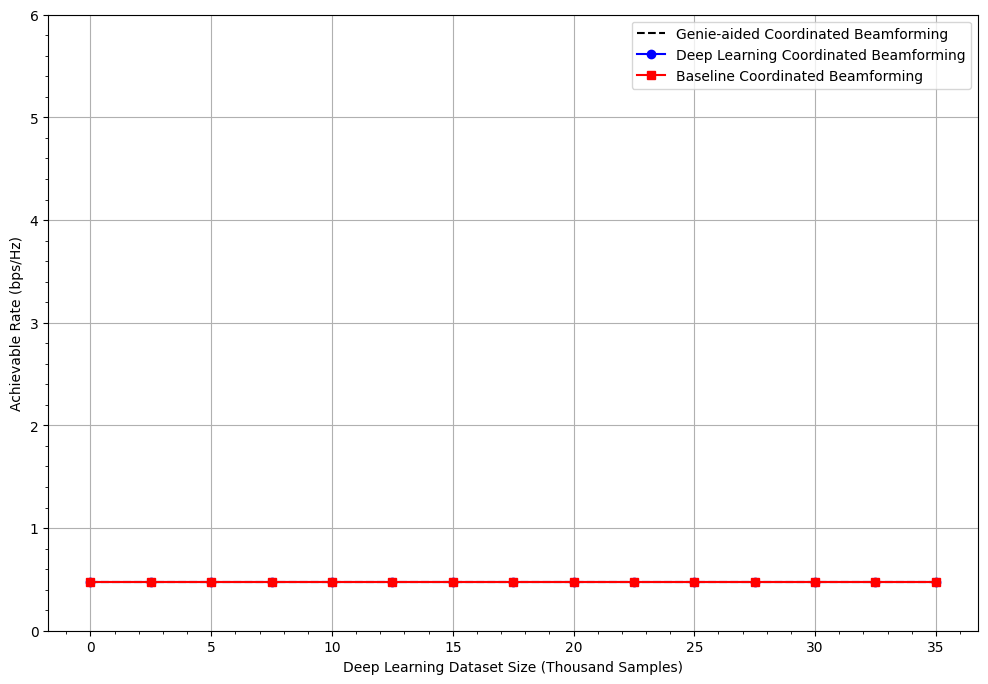

In [ ]:
import matplotlib.pyplot as plt

#%% Read Results
file_list = sorted(glob.glob('Test_code_output/DL_Result*'), key=lambda x: int(re.findall(r'\d+', x)[0]))
num_files = len(file_list)

user_index = []
pred_beams = []
opt_beams = []
for file in tqdm(file_list, desc='Reading DL results'):
    matfile = loadmat(file)
    l1 = []
    l2 = []
    for idx in range(num_bs):
        l1.append(matfile['TX'+str(idx+1)+'Pred_Beams'])
        l2.append(matfile['TX'+str(idx+1)+'Opt_Beams'])

    pred_beams.append(l1)
    opt_beams.append(l2)
    user_index.append(matfile['user_index'])


Pn = -204 + 10*np.log10(BW) # Noise power in dB
SNR = 10**(.1*(0-Pn))

ach_rate_DL = np.zeros(num_files)
ach_rate_opt = np.zeros(num_files)

eff_rate = np.zeros(num_files)
opt_rate = np.zeros(num_files)
for file_idx in tqdm(np.arange(num_files), desc = 'Calculating results'):
    user_index_file = user_index[file_idx].flatten()
    for ue_idx in range(len(user_index_file)):
        eff_ch = []
        opt_ch = []
        for bs_idx in range(num_bs):
            if file_idx == 0: # Random BF - 0 Samples
                pred_beam_idx = np.random.randint(num_beams)
            else:
                pred_beam_idx = np.argmax(pred_beams[file_idx][bs_idx][ue_idx])
            opt_beam_idx = np.argmax(opt_beams[file_idx][bs_idx][ue_idx])
            ch_single_bs = sionna_data['DL_input'][ue_idx, bs_idx, :]
            ch_single_bs = ch_single_bs.reshape(-1, 1)  # (64, 1)
            ch_single_bs = np.nan_to_num(ch_single_bs)
            beam_vec_pred = F[:, pred_beam_idx].reshape(-1, 1)  # (64, 1)
            beam_vec_opt = F[:, opt_beam_idx].reshape(-1, 1)    # (64, 1)

            eff_ch_single_pred = ch_single_bs.conj().T @ beam_vec_pred  # (1, 64) @ (64, 1) -> (1, 1)
            opt_ch_single_pred = ch_single_bs.conj().T @ beam_vec_opt

            eff_ch.append(eff_ch_single_pred.squeeze())
            opt_ch.append(opt_ch_single_pred.squeeze())

        eff_ch = np.array(eff_ch)
        opt_ch = np.array(opt_ch)
        eff_rate[file_idx] += np.log2(1 + SNR * np.sum(np.abs(eff_ch) ** 2))
        opt_rate[file_idx] += np.log2(1 + SNR * np.sum(np.abs(opt_ch) ** 2))

    eff_rate[file_idx] /= len(user_index_file)*num_OFDM
    opt_rate[file_idx] /= len(user_index_file)*num_OFDM


# % Eff achievable rate calculations
theta_user=(102/1)*np.pi/180
alpha=60*np.pi/180
distance_user=10
Tc_const=(distance_user*theta_user)/(2*np.sin(alpha)) # ms
Tt=10*1e-6; # ms

v_mph=50
v=v_mph*1000*1.6/3600 # m/s
Tc=Tc_const/v

overhead_opt=1-(num_beams*Tt)/Tc # overhead of beam training
overhead_DL=1-Tt/Tc # overhead of proposed DL method

#%% Plotting the figure
DL_size_array=np.arange(0, 2.5*(num_files), 2.5);
print(f"DL_size_array.shape: {DL_size_array.shape}, opt_rate.shape: {opt_rate.shape}")
print("opt_rate min/max:", opt_rate.min(), opt_rate.max())
print("eff_rate min/max:", eff_rate.min(), eff_rate.max())

fig, ax = plt.subplots()
plt.plot(DL_size_array, opt_rate, '--k', label = 'Genie-aided Coordinated Beamforming')
plt.plot(DL_size_array, eff_rate*overhead_DL, '-bo', label = 'Deep Learning Coordinated Beamforming')
plt.plot(DL_size_array, opt_rate*overhead_opt, '-rs', label = 'Baseline Coordinated Beamforming')
plt.ylim([0, 6])
plt.minorticks_on()
plt.grid()
plt.xlabel('Deep Learning Dataset Size (Thousand Samples)')
plt.ylabel('Achievable Rate (bps/Hz)')
plt.legend()
plt.savefig('result.png')
